In [1]:
import numpy as np
import igraph as ig

from numba import jit, njit
from scipy import sparse, stats
from gtda.homology import VietorisRipsPersistence

# Functions

## Network matrices

In [2]:
def edge_extractor(A):
    N = A.shape[0]
    indices = A.indices
    indptr  = A.indptr

    for i in range(N):
        for index in range(indptr[i], indptr[i+1]):
            j = indices[index]
            if j<i:
                continue
            yield i,j

@njit
def edge_extractor2(indptr, indices):
    N = len(indptr) - 1

    for i in range(N):
        for index in range(indptr[i], indptr[i+1]):
            j = indices[index]
            if j<i:
                continue
            yield i,j

In [3]:
def oriented_incidence_matrix(g):
    A = g.get_adjacency_sparse()
    N = A.shape[0]
    E = int(A.nnz/2)
    B = sparse.lil_matrix((E, N))

    edges = edge_extractor(A)
    # alternatively `map(lambda x:x.tuple, g.es)`

    for ei, (u,v) in enumerate(edges):
        B[ei, u] = -1
        B[ei, v] = 1
    return B

## Egde weights

In [4]:
def net_flow(g):
    L = np.array(g.laplacian())
    C = np.zeros(L.shape)
    C[1:,1:] = np.linalg.inv(L[1:,1:])

    N = len(g.vs)
    E = len(g.es)
    B = oriented_incidence_matrix(g)

    values = np.zeros(E)
    for idx, B_row in enumerate(B):
        F_row = B_row@C
        rank = stats.rankdata(F_row)
        values[idx] = np.sum((2*rank-1-N)*F_row)

    return values


def net_flow2(A):
    L = sparse.csgraph.laplacian(A).A
    C = np.zeros(L.shape)
    C[1:,1:] = np.linalg.inv(L[1:,1:])

    N = A.shape[0]
    E = A.nnz // 2
    
    edges = edge_extractor2(A.indptr, A.indices)

    values = np.zeros(E)
    for idx, (u,v) in enumerate(edges):
        F_row = C[v]-C[u]
        rank = stats.rankdata(F_row)
        values[idx] = np.sum((2*rank-1-N)*F_row)

    return values

In [5]:
def resistance(g):
    L = g.laplacian()
    Gamm = np.linalg.pinv(L)
    diag = np.diag(Gamm)
    return (-2*Gamm + diag).T + diag

## ring score

In [6]:
def diagram_to_sequence(dgm, homology_dimension = 1):
    persistences = sorted([death-birth for (birth, death, p) in dgm if p == 1], 
                                   reverse=True)
    signal = persistences[0]
    
    if signal == 0:
        return np.array([0.])
    else:
        return np.array(persistences) / signal

In [7]:
def ring_score(dgm):
    sequence = diagram_to_sequence(dgm)
    signal = sequence[0]
    
    if signal == 0:
        return 0
    else:
        return 1-sum((noise/signal) / 2**i for i,noise in enumerate(sequence[1:],1))

# Examples - resistance distance

In [8]:
VR = VietorisRipsPersistence(metric = "precomputed", homology_dimensions=[1])

### Ring graph

In [9]:
# Create graph
g = ig.Graph.Ring(2**9)

# Calculate distance matrix
D = resistance(g)

# PD of Vietoris-Rips complex
diagram, = VR.fit_transform([D])

print(f"Ring score of ring-graph is: {ring_score(diagram):.3f}")

Ring score of ring-graph is: 1.000


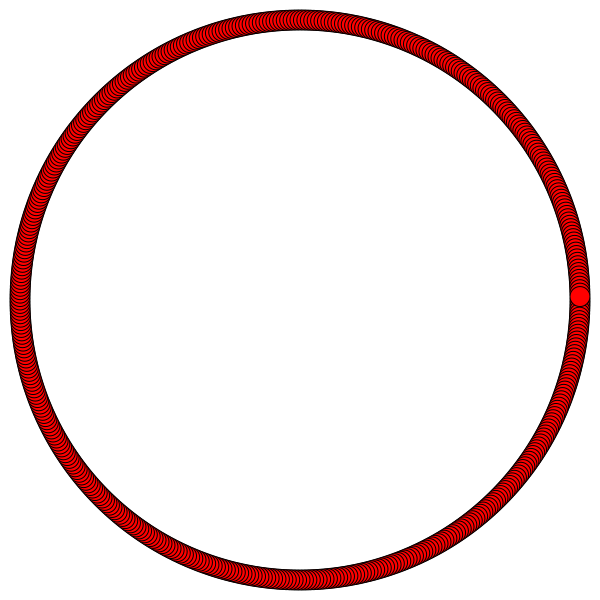

In [10]:
layout = g.layout("circle")
ig.plot(g, layout=layout)

### Geometric Random Graph

In [11]:
# Create graph
g = ig.Graph.GRG(2**9, 0.1)

# Calculate distance matrix
D = resistance(g)

# PD of Vietoris-Rips complex
diagram, = VR.fit_transform([D])

print(f"Ring score of GRG-graph is: {ring_score(diagram):.3f}")

Ring score of GRG-graph is: 0.276


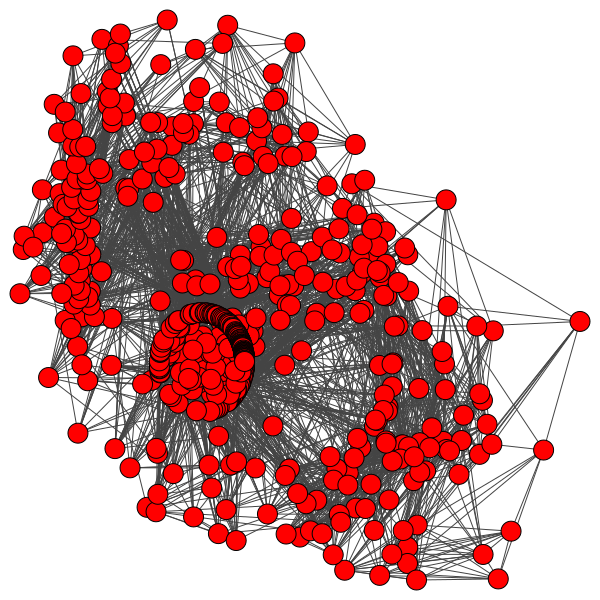

In [12]:
layout = g.layout("kk")
ig.plot(g, layout=layout)

## Examples - net-flow distance

In [13]:
g.es['net_flow'] = net_flow(g)

# use gtda implementation of geodesic distance

### speed comparison

In [14]:
g = ig.Graph.GRG(2**9, 0.1)

In [15]:
bb1 = net_flow(g)

A = g.get_adjacency_sparse()
bb2 = net_flow2(A)

(bb1 == bb2).all()

True

In [16]:
%%timeit 

bb1 = net_flow(g)

772 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit

A = g.get_adjacency_sparse()
bb2 = net_flow2(A)

274 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
772/274

2.8175182481751824